In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
df = pd.read_csv('../data/ee_joined.csv')
mp = pd.read_csv('../data/mp_joined.csv')

## Merging big wall cliffs to MP data

Running a merging operation to join the two dataframes. Earth Engine could not handle this calculation.

In [3]:
df['mp_counts'] = 0
df['num_rock_routes'] = 0
df['num_views'] = 0
df['distance_to_mp'] = None

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    filtered = mp[mp.custom_index == row.custom_index]
    mp_count = filtered.shape[0]
    if mp_count:
        df.at[i, 'mp_counts'] = mp_count
        df.at[i, 'num_rock_routes'] = filtered.num_rock_routes.sum()
        df.at[i, 'num_views'] = filtered.num_views.sum()
        df.at[i, 'distance_to_mp'] = filtered.distance_to_mp.mean()

100%|██████████| 35229/35229 [00:36<00:00, 968.10it/s] 


Now everything we need is inside the `df` dataframe. Dropping some left-over columns from Earth Engine and stuff we don't need.

In [4]:
df.drop(columns=['system:index', 'centroid', '.geo', 'custom_index', 'vicinity_mp_areas'], inplace=True)
df.columns

Index(['B2', 'B4', 'B42', 'B5', 'B6', 'B65', 'B67', 'B7', 'centroid_lith',
       'geology_alluvium', 'geology_carbonate', 'geology_colluvial_sediment',
       'geology_glacial_till_coarse', 'geology_non_carbonate',
       'geology_silicic_residual', 'height', 'latitude', 'longitude',
       'pixel_count', 'population_within_100km', 'population_within_200km',
       'population_within_30km', 'road_within_1000m', 'road_within_1500m',
       'road_within_2000m', 'road_within_3000m', 'road_within_500m',
       'vicinity_num_rock_routes', 'vicinity_num_views', 'mp_counts',
       'num_rock_routes', 'num_views', 'distance_to_mp'],
      dtype='object')

## Exploring association between Earth Engine-generated cliffs and MP data

Checking out the cliffs with associated MP areas. Many MP areas have their geo-tags well aligned with the location of the cliff according to earth engine.

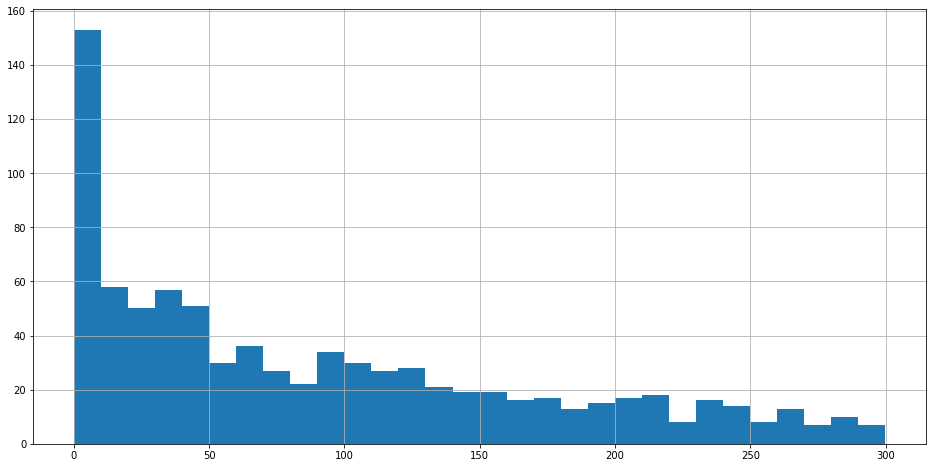

In [5]:
df.distance_to_mp.hist(bins=30)

Most cliffs have no associated MP areas. Some have many.

In [6]:
for n in range(20):
    print((df.mp_counts == n).sum())

34388
637
111
43
17
15
5
6
3
0
2
1
1
0
0
0
0
0
0
0


Are big walls viewed more on MP? Not really...

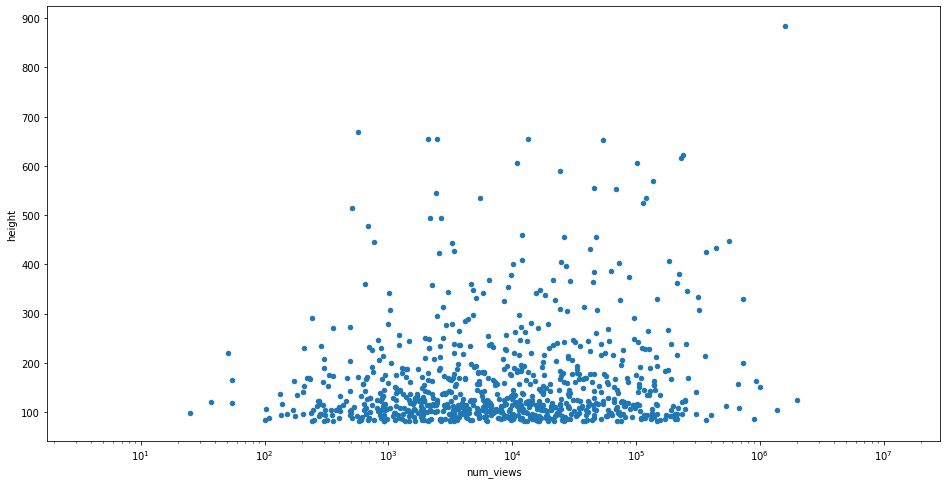

In [7]:
df[df.num_views > 0].plot(x='num_views', y='height', kind='scatter', logx=True);

But, as expected, big wall MP areas with more routes do get more views.

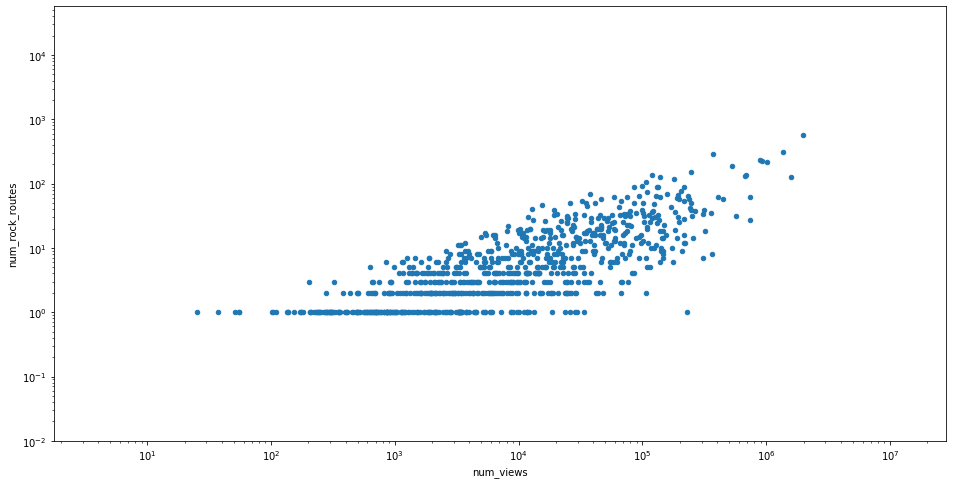

In [8]:
df[df.num_views > 0].plot(x='num_views', y='num_rock_routes', kind='scatter', loglog=True);

Cliffs for which MP geo tag doesn't align well with cliff location according to Earth Engine elevation data. These can be cross-referenced with the script in `ee_code_editor/explore_unmerged_data.js`. Some of these are aligned with actual cliffs; others are not.

In [9]:
df[df.distance_to_mp > 200][['latitude', 'longitude', 'height', 'num_rock_routes', 'distance_to_mp']].head(20)

,latitude,longitude,height,num_rock_routes,distance_to_mp
128,36.067025,-112.144964,262,8,206.853
689,37.732670,-119.574832,555,21,202.635
1515,38.045084,-107.677194,81,19,243.84
1576,37.098237,-118.521364,81,4,265.047
1738,37.247971,-112.964622,337,4,275.244
1973,37.626450,-110.584673,82,3,230.104
2039,36.099268,-115.483981,82,1,243.467
2040,36.062065,-115.479574,82,5,212.144
2041,36.086375,-115.477075,82,1,213.928
2172,38.693802,-109.541441,82,2,243.607


## Accessible cliffs

Eventually, we'll partition the data into two classes -- those that are accessible (and hence explored), and those that are inaccessible. Checking out possible partitions below.

In [10]:
print(f'Number of cliffs with MP entry: {(df.mp_counts > 0).sum()}')
print(f'Number of obscure cliffs with MP entry: {((df.mp_counts > 0) & (df.num_views < 1000)).sum()}')
print(f'Number of cliffs with MP in vicinity: {(df.vicinity_num_rock_routes > 0).sum()}')
print(f'Number of cliffs with nearby road and town: {((df.road_within_500m == 1) & (df.population_within_30km > 10_000)).sum()}')
print(f'Number of cliffs with nearby road and city: {((df.road_within_1000m == 1) & (df.population_within_100km > 500_000)).sum()}')

Number of cliffs with MP entry: 841
Number of obscure cliffs with MP entry: 133
Number of cliffs with MP in vicinity: 2701
Number of cliffs with nearby road and town: 919
Number of cliffs with nearby road and city: 880


In [11]:
accessible = (df.num_views > 1000) | (df.vicinity_num_views > 5000) | \
             ((df.road_within_500m == 1) & (df.population_within_30km > 10_000)) | \
             ((df.road_within_1000m == 1) & (df.population_within_100km > 500_000)) | \
             ((df.road_within_1500m == 1) & (df.population_within_100km > 1_000_000)) | \
             ((df.road_within_2000m == 1) & (df.population_within_100km > 2_000_000))

print(f'Number of accessibles: {accessible.sum()}')
print(f'Number of positives: {(df.num_views > 1000).sum()}')

Number of accessibles: 3650
Number of positives: 708


This is somewhat bad news -- we have a fairly small training set, and the training set is unbalanced. Still, smaller is better than nothing.

## Noise in the data

There are "holes" in the elevation dataset found at 'USGS/NED'. These holes give the appearance of deep wells within the elevation data. They form regions in which the elevation at several pixels is much lower than all of the surrounding elevation, and hence give "false positives". Manually removing these holds after studying the plot of height vs pixel_count. This removes roughly 1000 data points. Points above the red line are removed.

       height   latitude   longitude  pixel_count  num_rock_routes
34763    1517  38.914940 -105.447284           21                0
36       1281  38.694518 -114.250813          129                0
34018    1243  35.680132 -118.371031           69                0
20675    1141  41.125010 -106.000602          147                0
20676    1141  41.125766 -106.000017            1                0
20677    1141  41.125676 -105.999867            6                0
20678    1141  41.124774 -105.999837           23                0
20330     884  37.731722 -119.635903         2448              125
18849     880  48.971787 -121.002191          206                0
18850     880  48.975689 -120.995760          701                0
956       840  48.910145 -113.704846         1536                0
207       777  48.040483 -121.512820          621                0
35050     759  48.898919 -113.861067         1143                0
34650     746  47.780878 -121.581563         5125             

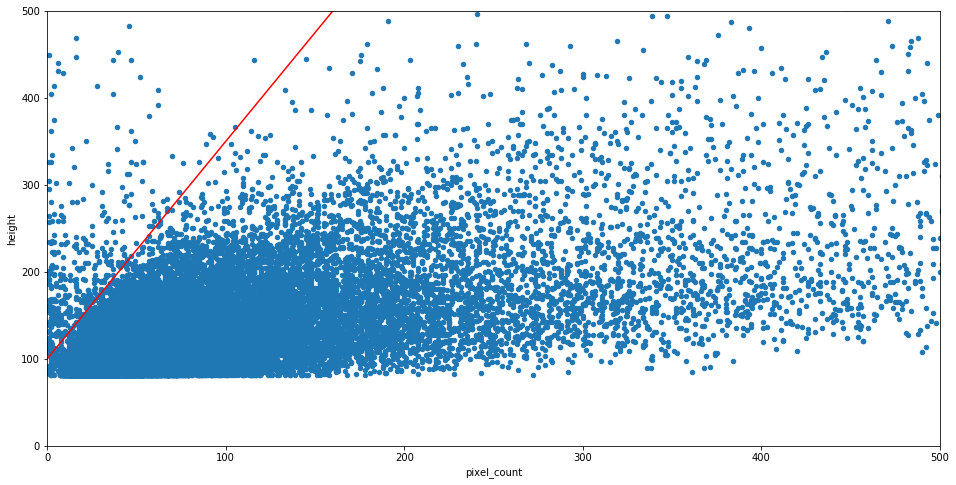

Number of data points removed: 591


In [12]:
print(df[df.height > 500].sort_values(by='height', ascending=False)[
      ['height', 'latitude', 'longitude', 'pixel_count', 'num_rock_routes']][:20])

df.plot(x='pixel_count', y='height', kind='scatter', xlim=(0, 500), ylim=(0, 500))
line = lambda x: 2.5 * x + 100
plt.plot([0, 1000], [line(0), line(1000)], 'k-', color='red')
plt.show()
mask = (df.height < 2.5 * df.pixel_count + 100) & (df.pixel_count > 10)
print(f'Number of data points removed: {(~mask).sum()}')
df = df[mask]

Other bits of noise exist in the data. Removing a few landsat bands with negative values.

In [13]:
mask = (df.B2 > 0) & (df.B4 > 0) & (df.B5 > 0) & (df.B6 > 0) & (df.B7 > 0)
print(f'Number of data points removed: {(~mask).sum()}')
df = df[mask]

Number of data points removed: 11


## Other trends

Now we visualize possible correlations among data values. ML models will flesh these out.

Possible lithology values: [ 1  3  5 19  7  8 11  0 14  4 13 16 10 17 18]


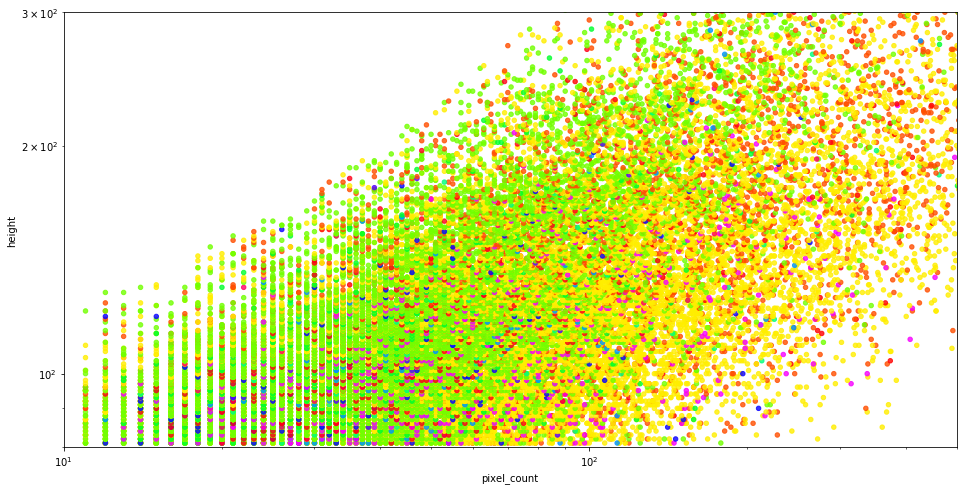

In [14]:
print(f'Possible lithology values: {df.centroid_lith.unique()}')
cmap = plt.cm.get_cmap('hsv', 20)
df.plot(x='pixel_count', y='height', c=df.centroid_lith.apply(lambda x: cmap(x)),
        alpha=0.8, kind='scatter', xlim=(10, 500), ylim=(80, 300), loglog=True);

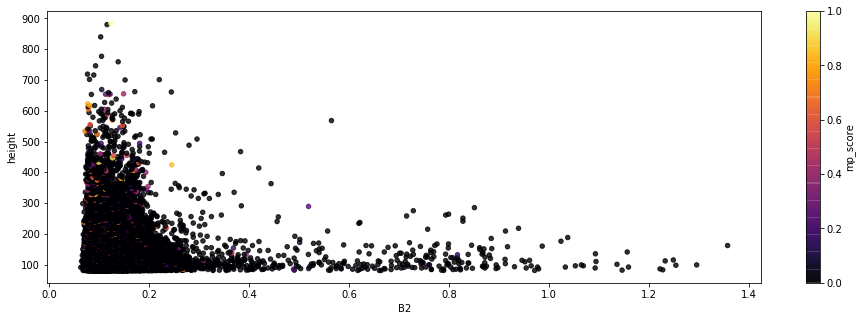

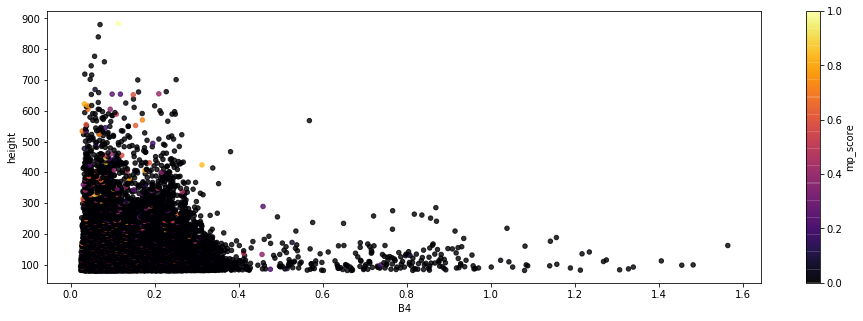

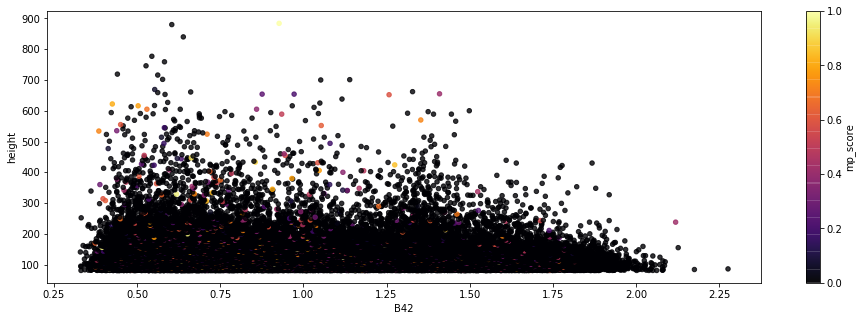

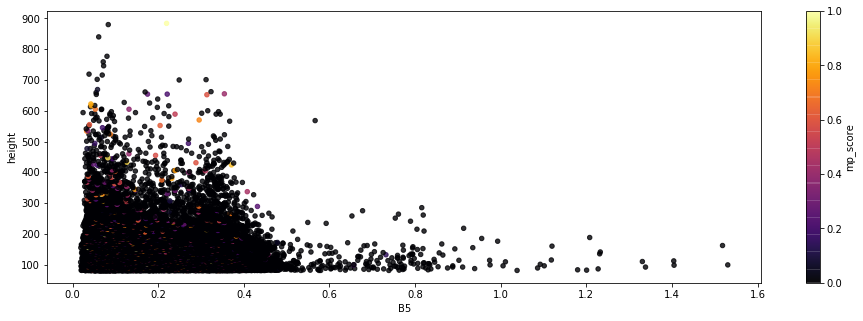

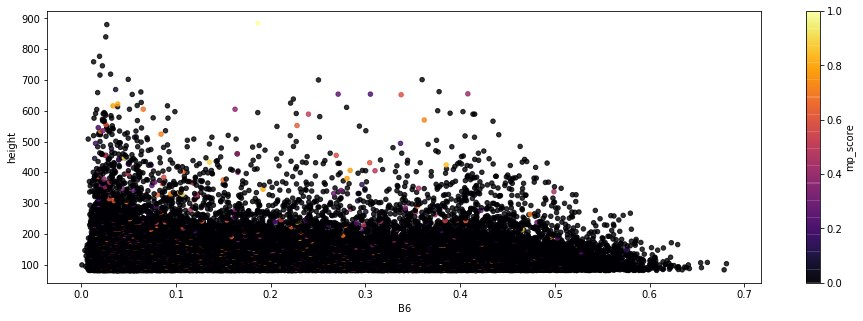

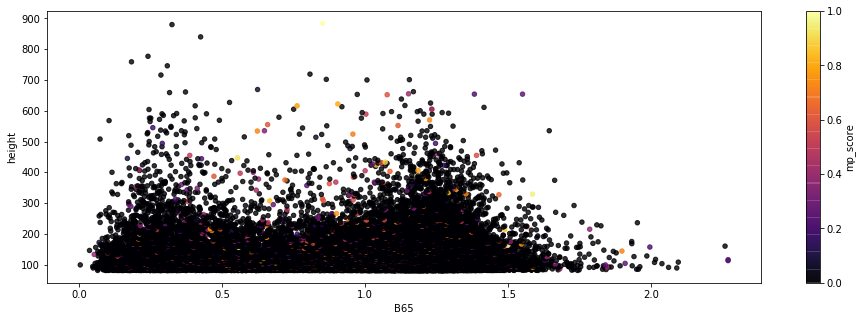

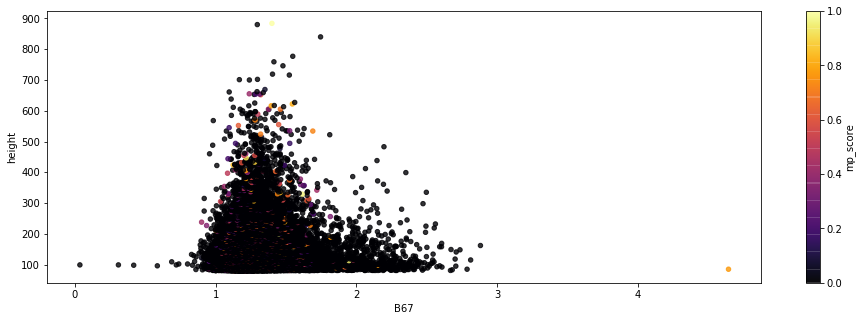

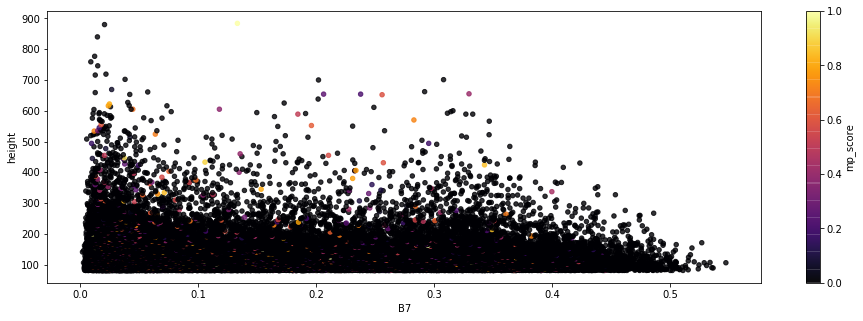

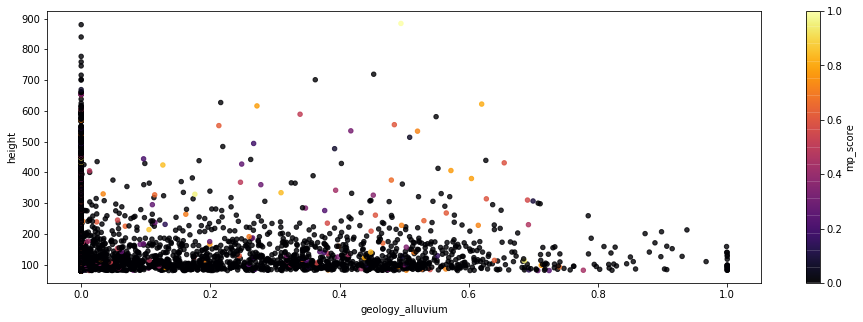

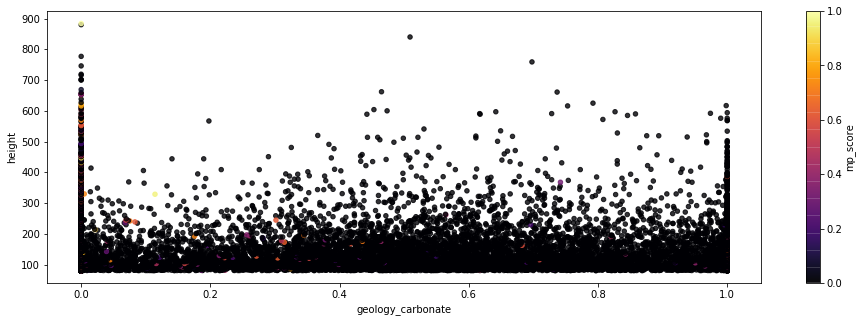

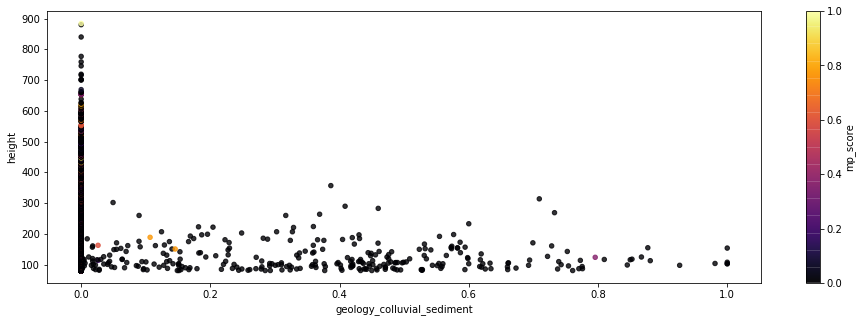

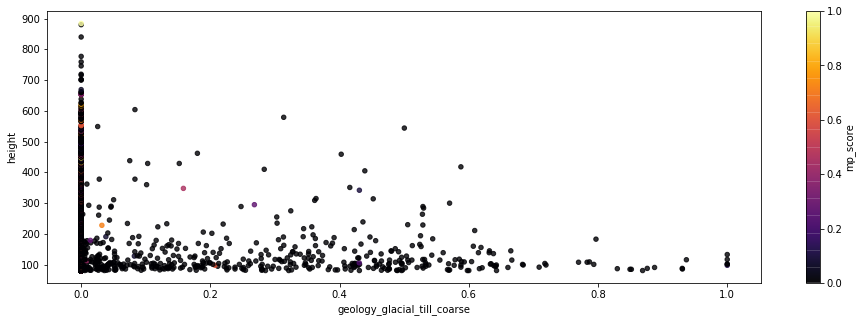

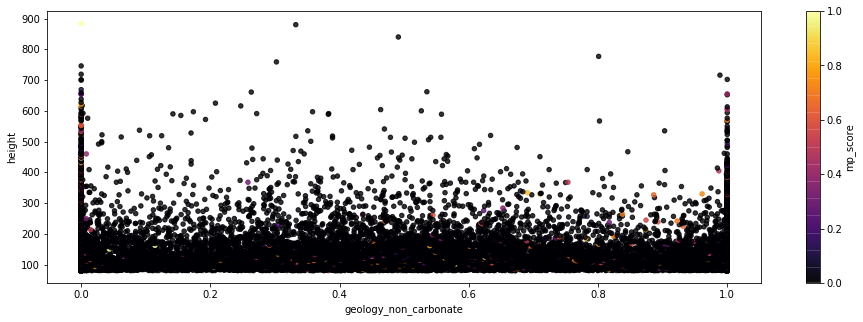

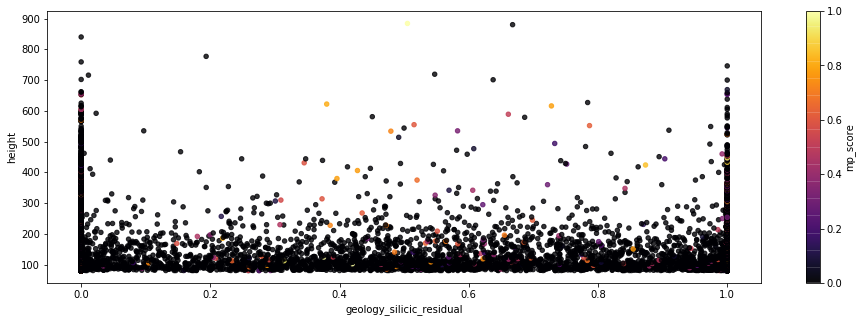

In [15]:
df['mp_score'] = (1000 * df.num_rock_routes + df.num_views).map(lambda x: 0 if x < 1000 else np.log2(x) / 10 - 1).clip(0, 1)


for label in ['B2', 'B4', 'B42', 'B5', 'B6', 'B65', 'B67', 'B7', 'geology_alluvium', 'geology_carbonate',
              'geology_colluvial_sediment', 'geology_glacial_till_coarse', 'geology_non_carbonate',
              'geology_silicic_residual']:
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(111)
    df.plot(x=label, y='height', kind='scatter', c='mp_score', alpha=0.8, colormap='inferno', ax=ax)
    plt.show()

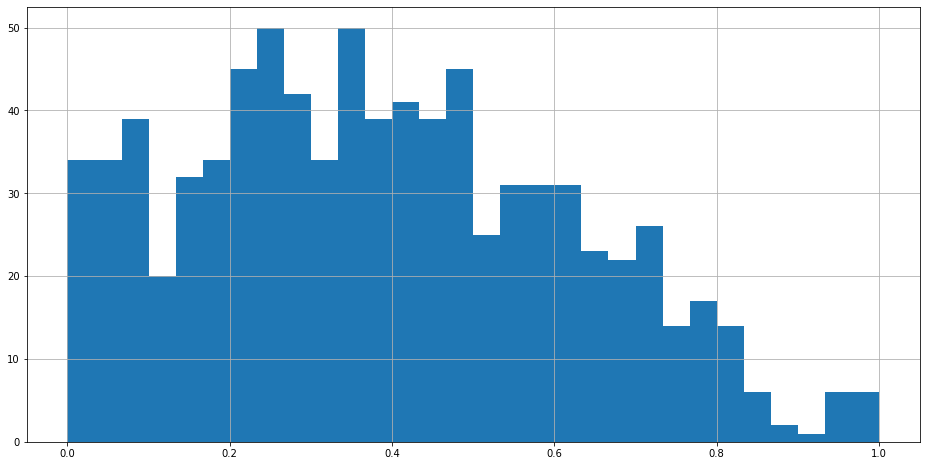

In [16]:
df.mp_score[df.mp_score > 0].hist(bins=30);

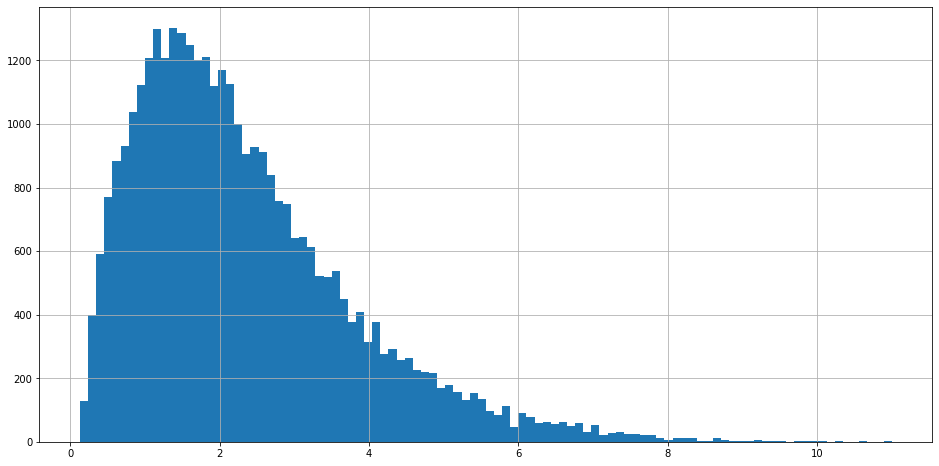

In [17]:
(df.height / df.pixel_count).hist(bins=100);

Looking at crags with highest `mp_score`. El cap has a score of 1.0, as does some stuff in Eldo, Tahquitz, and Smith Rock.

In [18]:
df.sort_values(by='mp_score', ascending=False)[['mp_score', 'latitude', 'longitude', 'height', 'distance_to_mp']][:30]

,mp_score,latitude,longitude,height,distance_to_mp
22956,1.000000,39.931308,-105.285257,125,153.078
4416,1.000000,33.760540,-116.683779,85,136.498
14888,1.000000,39.931820,-105.286176,103,142.009
28122,1.000000,44.364094,-121.146741,151,76.585
29766,1.000000,44.367793,-121.140322,163,100.742
20330,1.000000,37.731722,-119.635903,884,49.1862
17027,0.964086,38.547331,-109.599006,108,56.2307
957,0.960709,36.035968,-115.468416,329,54.794
28868,0.960615,38.800348,-120.134458,156,118.26
33134,0.953903,43.742485,-110.803257,200,114.461
